# LEARNING OBJECTIVE

This notebook illustrates how to compute the kinematic quantities associated with a velocity field, as well as how to compute acceleration with the material derivative. Symbolic computing tools are used to do the vector calculus. The connections between vectors and tensors and their representations as array and matrices is highlighted.

# PRELIMINARIES

[run the next cell to setup Python environment customizations and load packages]

In [1]:
# interactive plots setup
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# sympy setup
import sympy as sp
sp.init_printing()
from sympy.vector import *

# ploting customizations
from matplotlib import pyplot as plt
size=16
params = {'legend.fontsize': 'large',
#          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.875,
          'ytick.labelsize': size*0.875,
          'axes.titlepad': 25}
plt.rcParams.update(params)
%matplotlib inline

# numerics
import numpy as np

# to save plots as files and download them
# from google.colab import files

## Credit

Initial version written by [Ivan C. Christov](http://christov.tmnt-lab.org), Purdue University.

# INTRODUCTION

Inspired by Powers' _Mechanics of Fluids_, Prob. 3.6, consider a two-dimensional Cartesian flow field with velocity vector, $\underline{v} = v_i \underline{e}_i$, the components of which are
\begin{align*}
  v_1 &= -c x_1 + 4 c x_2,\\
  v_2 &= -c 4 x_1 - c x_2,\\
  v_3 &= 0,
\end{align*}
where $c>0$ is a suitable dimensional constant.

# DEMONSTRATION


We will setup a coordinate system using SymPy's [capabilities](https://docs.sympy.org/latest/modules/vector/fields.html) for our analyical calculations.

In [2]:
from sympy.vector import CoordSys3D, Del
C = CoordSys3D('C') # C.x, C.y, C.z are the coordinates 
                    # C.i, C.j, C.k are the unit vectors
# define the nabla operator
nabla = Del()

Define the velocity vector in terms of the unit vectors of our coordinate system from SymPy.


In [3]:
c = sp.Symbol('c', positive='True')
v = (-c*C.x + 4*c*C.y) * C.i + (-c*4*C.x - c*C.y) * C.j + 0 * C.k
# other example velocity fields you could play with:
# v = c*(1-(C.y)**2) * C.i + 0 * C.j + 0 * C.k
# v = c*C.x * C.i - c*C.y * C.j + 0 * C.k
v

## Vorticity, $\nabla\times\underline{v}$

To determine whether the flow field is locally rotational or irrotational, we compute the vorticity.

In [4]:
# general expression
vorticity = (nabla ^ v).doit() # in SymPy ^ is one way to denote a cross product
                               # (also used in some books), instead of \times

# evaluated expression
vorticity

## Kinematic quantities and how they are related, $\nabla\underline{v}$

The flow kinematics are determined by the velocity field's gradient, the tensor $\nabla \underline{v}$.

SymPy doesn't have built-in functionality for gradient of a vector (yet). But we can take a [derivative of a vector with respect to a vector](https://docs.sympy.org/latest/modules/tensor/array.html#derivatives-by-array) (like a "Jacobian").

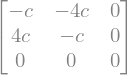

In [5]:
# we need to express the vector via an array of components for the next step
# so, take the dot product of v with each coord vector to get the 3 components
# in SymPy, & is one way to form a dot product
v_array = [ v & C.i, v & C.j, v & C.k ]

gradv = sp.derive_by_array(v_array, [C.x, C.y, C.z])

# convert v and grad v to SymPy matrices
v_array = sp.Matrix(v_array)
gradv = sp.Matrix(gradv)
gradv

The symmetric part, $S_{ij} = \partial_{(i}v_{j)} = \frac{1}{2}(\partial_i v_j + \partial_j v_i)$, of the velocity gradient contains information on the shear and extensional motions caused by the velocity field.

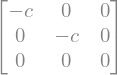

In [6]:
# 1/2 is a float, Rational(1,2) is a symbolic expression for 1/2,
# which lets SymPy do algebra more easily
Sij = sp.Rational(1,2)*(gradv + gradv.transpose())
Sij

The shear rate _magnitude_ for the flow is defined using a [double contraction](https://docs.sympy.org/latest/modules/tensor/array.html#products-and-contractions) of $S_{ij}$ with itself. We can implent this operation using some SymPy functions.

In [7]:
SS = sp.sqrt(sp.tensorcontraction(sp.tensorcontraction(sp.tensorproduct(Sij,Sij), (1, 2)), (0, 1)))
SS.simplify()

The anti-symmetric part, $\Omega_{ij} = \partial_{[i}v_{j]} = \frac{1}{2}(\partial_i v_j - \partial_j v_i)$, of the velocity gradient contains information about rotational motions caused by the velocity field.

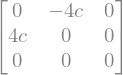

In [8]:
Omegaij = sp.Rational(1,2)*(gradv - gradv.transpose())
Omegaij

To drive the point about $\Omega_{ij}$ home, we compute the _dual vector_ $d_k$ of $\Omega_{ij}$ from the definition given in Panton's Eq. (3.7.4), namely $d_k = \epsilon_{kij}\Omega_{ij}$.

We could use fancy double contraction operations (but I had a hard time figuring it out in the context of $\epsilon_{ijl}$ in SymPy).

So let's brute-force it with some loops.

In [9]:
# initialize d_k as a zero matrix
dvec = sp.Matrix([0,0,0])

for k in 1,2,3:
  dvec[k-1,0] = 0
  for i in 1,2,3:
    for j in 1,2,3:
      dvec[k-1,0] = dvec[k-1,0] + sp.LeviCivita(k,i,j)*Omegaij[i-1,j-1]

d = dvec[0,0] * C.i + dvec[1,0] * C.j + dvec[2,0] * C.k
d

And, we verify that $d_k = \omega_k$ is the precisely the vorticity vector.

In [10]:
d == vorticity

True

Finally, we verify that the kinematic decomposition, $\partial_i v_j = S_{ij} + \Omega_{ij}$, works.

In [11]:
gradv == Sij + Omegaij

True

## Volume rate of expansion, $\nabla\cdot\underline{v}$

The average rate of expansion caused by the flow is given by the divergence of the velocity field, $\nabla\cdot\underline{v}$.

In [12]:
divv = (nabla & v).doit()
divv = sp.simplify(divv)
divv

If $\nabla\cdot\underline{v}=0$, then the flow has no local volume expanstion, that is, it is an incompressible _flow_. Otherwise, fluid elements change volume under the action of this flow. 

We can also verify the identity that $\nabla\cdot\underline{v} = \partial_i v_i = S_{ii} = \mathrm{tr}\underline{\underline{S}}$.

In [13]:
divv == sp.trace(Sij)

True

## Acceleration, the material derivative of the velocity


The acceleration at a point in space is $D\underline{v}/Dt=\partial_t \underline{v} + (\underline{v}\cdot\nabla)\underline{v}$. The chosen flow is steady, so $\partial_t \underline{v} = \underline{0}$ and we have only convective acceleration.

First, we compute the convective acceleration using the directional derivative interpretation as $v_j\partial_j v_i = (v_j\partial_j)v_i = (\underline{v}\cdot\nabla)\underline{v}$ and [SymPy vector calculus](https://docs.sympy.org/latest/modules/vector/fields.html#directional-derivative).

In [14]:
# in SymPy, & is one way to form a dot product
vdotgradv = (v & nabla)(v)
vdotgradv = sp.simplify(vdotgradv)
vdotgradv

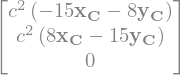

In [15]:
# reprint it as a vertical array for easier reading
vdotgradv_array = sp.Matrix([ [vdotgradv & C.i], [vdotgradv & C.j], [vdotgradv & C.k] ])
vdotgradv_array = sp.simplify(vdotgradv_array)
vdotgradv_array

Second, we compute the convective acceleration using the matrix-vector product interpretation as $ v_j \partial_j v_i = (\partial_j v_i)v_j = [\nabla\underline{v}]^{\rm T} \underline{v}$.

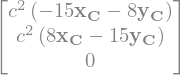

In [16]:
sp.simplify(gradv.transpose() * v_array)

We verify the first and second methods agree.

In [17]:
vdotgradv_array == sp.simplify(gradv.transpose() * v_array)

True

The vesion without the transpose, $[\nabla \underline{v}]\underline{v}$, doesn't give the same (right) answer!

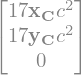

In [18]:
sp.simplify(gradv * v_array)

In [19]:
vdotgradv_array == sp.simplify(gradv * v_array)

False